# Image Resolution Enhancement using Convolutional Neural Networks

The purpose of this project is to develop a quick and efficient method to construct a high resolution image from a low resolution input image. I have employed a shallow convolutional neural network for this purpose and used the PIRM dataset containing low and high resolution images for training. 

The primary advantage of this approach is that it uses a shallow network, thus allowing fast and easy computation utilising minimal storge space. This provides scope for utilising the model under limited storage and time constraints. Further development of the model could make it a strong candidate for usage in mobile and low cost applications.

### Providing Google Colab access to required files in Google Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fid = drive.ListFile({'q':"title='pirm_dataset.zip'"}).GetList()[0]['id']    #Enter dataset name as title here
f = drive.CreateFile({'id': fid})
f.GetContentFile('pirm_dataset.zip')      #Enter dataset name here.

In [0]:
fid = drive.ListFile({'q':"title='pirm_validation.zip'"}).GetList()[0]['id']    #Enter dataset name as title here
f = drive.CreateFile({'id': fid})
f.GetContentFile('pirm_validation.zip')      #Enter dataset name here.

In [0]:
fid = drive.ListFile({'q':"title='thml_imgs.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('thml_imgs.zip')      #Enter dataset name here.

In [0]:
fid = drive.ListFile({'q':"title='rgb_imgs.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('rgb_imgs.zip')

In [0]:
fid = drive.ListFile({'q':"title='Test.zip'"}).GetList()[0]['id']    #Enter dataset name as title here
f = drive.CreateFile({'id': fid})
f.GetContentFile('Test.zip')      #Enter dataset name here.

In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [397]:
# To allow colab to access Google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


### Loading necessary packages

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Multiply, Subtract, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import l2
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform, he_normal
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
K.set_image_data_format('channels_last') 
K.set_learning_phase(1)  
import scipy
import cv2
from keras.layers import subtract
import keras
from keras.layers import Lambda
import tensorflow as tf 
from keras.optimizers import SGD, RMSprop, Adadelta     
from keras import losses
import PIL as PIL
from PIL import Image


### Separate preprocessing steps are used for low and high resolution images. 
We use Cubic interpolation to upscale the low resolution image to the required size.

In [0]:
# Preprocessing input for Low res images

def preprocessing_input_LR(X_input):  
    return cv2.resize(X_input,(270,360),fx=4,fy=4, interpolation = cv2.INTER_CUBIC)

In [0]:
# Preprocessing input for high res images

def preprocessing_input_HR(X_input):  
    X_input = cv2.resize(X_input,(270,360)) 
    return X_input

### Loading the training datasets of low and high resolution images
X_train and X_train2 contain low res images.
Y_train and Y_train2 contain the corresponding high res images.

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='pirm_validation.zip'
X_train=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(90):
        img_path='pirm_validation/4x_downsampled/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        X_train.append(x) 

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='Test.zip'
X_train_2=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(201,290):
        img_path='Test/4x_downsampled/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        X_train_2.append(x) 

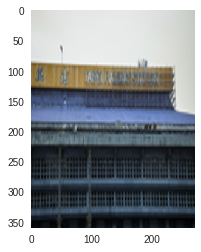

In [403]:
im = Image.fromarray(X_train[2])
imshow(im) 
plt.grid(None)

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='pirm_validation.zip'
Y_train=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(90):
        img_path='pirm_validation/Original/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        Y_train.append(x) 

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='Test.zip'
Y_train_2=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(201,290):
        img_path='Test/Original/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        Y_train_2.append(x) 

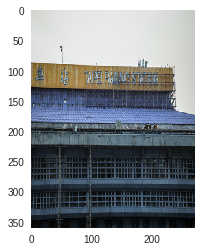

In [405]:
im = Image.fromarray(Y_train[2])
imshow(im) 
plt.grid(None)

In [0]:
X_train=np.asarray(X_train)
X_train_temp=X_train
#X_train=np.expand_dims(X_train, axis=3)

In [0]:
Y_train=np.asarray(Y_train) 
Y_train_temp=Y_train
#Y_train=np.expand_dims(Y_train, axis=3)

In [0]:
X_train_2=np.asarray(X_train)
X_train_temp_2=X_train
#X_train=np.expand_dims(X_train, axis=3)

In [0]:
Y_train_2=np.asarray(Y_train) 
Y_train_temp_2=Y_train
#Y_train=np.expand_dims(Y_train, axis=3)

### Model architecture

In [0]:
def thmlmodel(input_shape):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D((3,3))(X_input)
    
    X=Conv2D(64, (7, 7), activation='relu', name='conv11', subsample=(1,1), input_shape= input_shape, 
                        init='he_normal')(X)
    
    X=ZeroPadding2D((2, 2))(X)
    
    X=Conv2D(32, (5, 5), activation='relu', name='conv21', subsample=(1, 1), init='he_normal')(X)
    
    X=ZeroPadding2D((1, 1))(X)
    
    X=Conv2D(32, (3, 3), activation='relu', name='conv31', subsample=(1, 1), init='he_normal')(X)
    
    X=ZeroPadding2D((1, 1))(X)
    
    X=Conv2D(3, (3, 3), activation='relu', name='conv41', subsample=(1,1), init='he_normal')(X)
    
    model = Model(inputs = X_input, outputs = X, name='thmlmodel')
    
    return model

In [436]:
mymodel=thmlmodel((360,270,3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), activation="relu", name="conv11", input_shape=(360, 270,..., strides=(1, 1), kernel_initializer="he_normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", name="conv21", strides=(1, 1), kernel_initializer="he_normal")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv31", strides=(1, 1), kernel_initializer="he_normal")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (3, 3), activation="relu", name="conv41", strides=(1, 1), kernel_initializer="he_normal")`


In [0]:
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
mymodel.compile(optimizer=rms,loss=losses.mean_squared_error) 

In [438]:
X_train.shape

(90, 360, 270, 3)

In [467]:
mymodel.fit(x=X_train,y=Y_train,epochs=30, batch_size=10) 

Epoch 1/30
90/90 [==============================] - 3s 37ms/step - loss: 330.7465
Epoch 2/30
90/90 [==============================] - 3s 35ms/step - loss: 314.0775
Epoch 3/30
90/90 [==============================] - 3s 36ms/step - loss: 330.6033
Epoch 4/30
90/90 [==============================] - 3s 36ms/step - loss: 328.1920
Epoch 5/30
90/90 [==============================] - 3s 36ms/step - loss: 298.3439
Epoch 6/30
90/90 [==============================] - 3s 36ms/step - loss: 338.0920
Epoch 7/30
90/90 [==============================] - 3s 36ms/step - loss: 322.8174
Epoch 8/30
90/90 [==============================] - 3s 36ms/step - loss: 300.4344
Epoch 9/30
90/90 [==============================] - 3s 36ms/step - loss: 311.5342
Epoch 10/30
90/90 [==============================] - 3s 36ms/step - loss: 320.2385
Epoch 11/30
90/90 [==============================] - 3s 36ms/step - loss: 309.8596
Epoch 12/30
90/90 [==============================] - 3s 36ms/step - loss: 319.5797
Epoch 13/30
9

In [503]:
mymodel.fit(x=X_train_2,y=Y_train_2,epochs=30, batch_size=10) 

Epoch 1/30
90/90 [==============================] - 3s 38ms/step - loss: 291.7880
Epoch 2/30
90/90 [==============================] - 3s 35ms/step - loss: 306.1282
Epoch 3/30
90/90 [==============================] - 3s 36ms/step - loss: 279.7769
Epoch 4/30
90/90 [==============================] - 3s 35ms/step - loss: 288.6211
Epoch 5/30
90/90 [==============================] - 3s 36ms/step - loss: 307.4326
Epoch 6/30
90/90 [==============================] - 3s 35ms/step - loss: 265.5373
Epoch 7/30
90/90 [==============================] - 3s 35ms/step - loss: 295.0368
Epoch 8/30
90/90 [==============================] - 3s 36ms/step - loss: 300.9629
Epoch 9/30
90/90 [==============================] - 3s 36ms/step - loss: 283.2543
Epoch 10/30
90/90 [==============================] - 3s 36ms/step - loss: 294.2738
Epoch 11/30
90/90 [==============================] - 3s 36ms/step - loss: 282.0732
Epoch 12/30
90/90 [==============================] - 3s 36ms/step - loss: 289.1896
Epoch 13/30
9

### Loading the test set
X_test contains low resolution RGB images and Y_test contains high resolution RGB images.
Note that the images in Y_test are not provided to the model at any stage. They are only used to compare the model output with the ground truth it contains.

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='pirm_validation.zip'
X_test=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(91,100):
        img_path='pirm_validation/4x_downsampled/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        X_test.append(x) 

In [0]:
X_test=np.asarray(X_test)
X_test_temp=X_test
#X_test=np.expand_dims(X_test, axis=3)

In [0]:
# opening the zip file in READ mode

from zipfile import ZipFile
file_name='pirm_validation.zip'
Y_test=[]
with ZipFile(file_name, 'r') as zf:
    # printing all the contents of the zip file
    #zf.printdir()
    zf.extractall() 
    for i in range(91,100):
        img_path='pirm_validation/Original/'+str(i+1)+'.png'
        img = Image.open(img_path)
        #print(type(img))
        x = np.array(img)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x=preprocessing_input_LR(x)
        Y_test.append(x) 

In [0]:
Y_test=np.asarray(Y_test)
Y_test_temp=Y_test
#Y_test=np.expand_dims(Y_test, axis=3)

In [0]:
t1 = mymodel.predict(X_test).astype('uint8')
im = Image.fromarray(t1[3])

In [273]:
#Useful values to check to make sure that the dimensions work as expected.
t1.shape            #should be (x,360,270,3) 
X_test_temp.shape   #should be (x,360,270,3)
X_train[2].shape   
Y_test_temp.shape

(9, 360, 270, 3)

### Checking model performance
Change the value of k in the check_results_rgb function to see the model outputs for different test images.
The images that the function outputs from left to right are
1. The model output
2. The low resolution test input
3. The high resolution image

In [0]:
def check_results_rgb(k):
  fig=plt.figure(figsize=(15,15))
  columns = 3
  rows = 1
  fig.add_subplot(rows, columns, 1)
  im = Image.fromarray(t1[k])
  imshow(np.asarray(t1[k])) 
  plt.grid(None)
  fig.add_subplot(rows, columns, 2)
  plt.imshow(X_test_temp[k])
  plt.grid(None)
  fig.add_subplot(rows, columns, 3)
  plt.imshow(Y_test_temp[k])
  plt.grid(None)

In [0]:
import h5py
mymodel.save_weights('model_weights_thml_2nd.h5')   

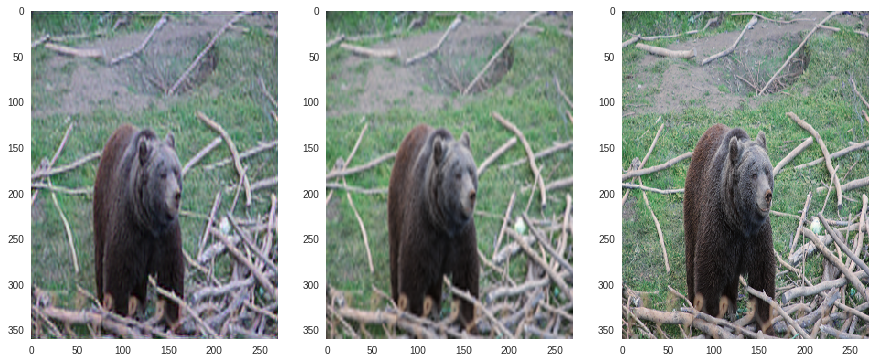

In [477]:
check_results_rgb(4)

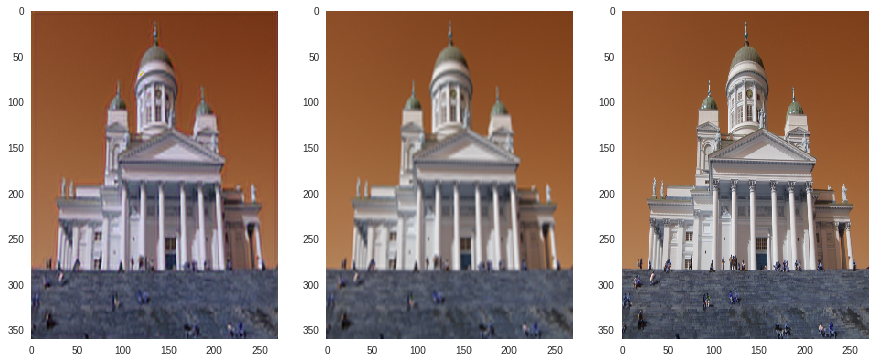

In [485]:
check_results_rgb(1)

In [0]:
#60 epochs on X_train,Y_train - batch size 10
import h5py
mymodel.save_weights('model_weights_thml.h5')   

In [0]:
#90 epochs on X_train,Y_train - batch size 10
import h5py
mymodel.save_weights('model_weights_thml_3rd.h5')   

In [0]:
#60 epochs with batchsize of 10 on X_train,Y_train followed by 30 epochs with batchsize of 10 on X_train2,Y_train2
#Obtained best results with this.
import h5py
mymodel.save_weights('model_weights_thml_final.h5') 

### Conclusion

I have tried out multiple model architectures with varying batch sizes and the following training sequence proved to provide stronger results :
X_train   -- 60 epochs -- Batch size 10
X_train_2 -- 30 epochs -- Batch size 10

For better performance, the model could be improved by more rounds of training and more generalised datasets. I am also making attempts at utilising a similar model architecture for the purpose of thermal image superresolution.